In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchdiffeq as tdf

import numpy as np

In [4]:
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')
t = torch.linspace(0., 25., 1000).to(device)
true_A = torch.tensor([[-0.1,2.0], [-2.0, -0.1]]).to(device)
true_y0 = torch.tensor([[2.,0.]]).to(device)
class Lambda(nn.Module):
    def forward(self, t,y):
        return torch.mm(y**3, true_A)

        
with torch.no_grad():
    true_y = tdf.odeint(Lambda(), true_y0, t, method="dopri5")
    
true_y_adjoint = tdf.odeint_adjoint(Lambda(), true_y0, t, method="dopri5")

print(true_y)
print(true_y_adjoint)

tensor([[[ 2.0000,  0.0000]],

        [[ 1.9795,  0.3944]],

        [[ 1.9494,  0.7742]],

        ...,

        [[-0.4418,  0.2882]],

        [[-0.4427,  0.2839]],

        [[-0.4436,  0.2794]]])
tensor([[[ 2.0000,  0.0000]],

        [[ 1.9795,  0.3944]],

        [[ 1.9494,  0.7742]],

        ...,

        [[-0.4418,  0.2882]],

        [[-0.4427,  0.2839]],

        [[-0.4436,  0.2794]]])


In [43]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(900, dtype=np.int64), 300, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:100]  # ()
    batch_y = torch.stack([true_y[s + i] for i in range(100)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)




In [44]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(2,50),
            nn.Tanh(),
            nn.Linear(50,2),
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
    def forward(self, t, y):
        return self.net(y**3)

In [45]:
get_batch()

(tensor([[[ 4.5714e-01,  3.8931e-01]],
 
         [[ 3.0956e-01,  6.8544e-01]],
 
         [[ 9.9325e-01,  4.5710e-01]],
 
         [[ 3.4318e-01,  4.7196e-01]],
 
         [[-4.7895e-01, -5.2158e-01]],
 
         [[ 7.3285e-01,  6.0925e-02]],
 
         [[-4.2488e-01,  6.2510e-01]],
 
         [[ 1.4452e+00, -2.4749e-01]],
 
         [[-1.2745e-01, -8.0609e-01]],
 
         [[-4.1817e-01, -1.1318e+00]],
 
         [[ 3.5902e-01,  4.6624e-01]],
 
         [[ 1.0051e+00,  3.5746e-01]],
 
         [[ 1.0411e+00, -3.4466e-01]],
 
         [[ 6.9875e-01,  3.9663e-01]],
 
         [[ 7.0907e-01,  3.4459e-01]],
 
         [[-1.4556e-01, -5.7985e-01]],
 
         [[-5.6331e-01, -1.1269e+00]],
 
         [[-8.8149e-01,  3.2318e-01]],
 
         [[ 1.4776e-01,  6.8409e-01]],
 
         [[-5.9956e-01,  4.5860e-01]],
 
         [[-2.3323e-01, -8.1010e-01]],
 
         [[ 4.0418e-01, -5.0870e-01]],
 
         [[ 4.6511e-01, -4.5959e-01]],
 
         [[-6.1239e-01, -1.8555e-01]],
 
         [[ 5.85

In [47]:
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

while True:
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = tdf.odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    if loss < 5e-3:
        break
    print(str(loss) +'/n')
    optimizer.step()

tensor(0.5324, grad_fn=<MeanBackward0>)/n
tensor(0.4809, grad_fn=<MeanBackward0>)/n
tensor(0.4439, grad_fn=<MeanBackward0>)/n
tensor(0.4883, grad_fn=<MeanBackward0>)/n
tensor(0.4741, grad_fn=<MeanBackward0>)/n
tensor(0.4617, grad_fn=<MeanBackward0>)/n
tensor(0.4470, grad_fn=<MeanBackward0>)/n
tensor(0.4322, grad_fn=<MeanBackward0>)/n
tensor(0.4120, grad_fn=<MeanBackward0>)/n
tensor(0.4413, grad_fn=<MeanBackward0>)/n
tensor(0.4450, grad_fn=<MeanBackward0>)/n
tensor(0.4308, grad_fn=<MeanBackward0>)/n
tensor(0.4442, grad_fn=<MeanBackward0>)/n
tensor(0.4434, grad_fn=<MeanBackward0>)/n
tensor(0.4141, grad_fn=<MeanBackward0>)/n
tensor(0.4172, grad_fn=<MeanBackward0>)/n
tensor(0.4259, grad_fn=<MeanBackward0>)/n
tensor(0.4123, grad_fn=<MeanBackward0>)/n
tensor(0.4108, grad_fn=<MeanBackward0>)/n
tensor(0.3798, grad_fn=<MeanBackward0>)/n
tensor(0.4084, grad_fn=<MeanBackward0>)/n


KeyboardInterrupt: 

In [39]:
import matplotlib.pyplot as plt

In [40]:
all = tdf.odeint(func, true_y0, t)

t2 = torch.Tensor([i[0][0] for i in all])
y_pred = torch.Tensor([i[0][1] for i in all])

In [41]:
torch.Tensor([i[0][0] for i in true_y])
torch.Tensor([i[0][1] for i in true_y])


tensor([ 0.0000e+00,  3.9436e-01,  7.7416e-01,  1.1273e+00,  1.4297e+00,
         1.6546e+00,  1.7912e+00,  1.8526e+00,  1.8658e+00,  1.8566e+00,
         1.8413e+00,  1.8256e+00,  1.8060e+00,  1.7715e+00,  1.7067e+00,
         1.5973e+00,  1.4370e+00,  1.2316e+00,  9.9564e-01,  7.4510e-01,
         4.9155e-01,  2.4106e-01, -4.3615e-03, -2.4454e-01, -4.7911e-01,
        -7.0591e-01, -9.1998e-01, -1.1135e+00, -1.2776e+00, -1.4050e+00,
        -1.4936e+00, -1.5469e+00, -1.5725e+00, -1.5794e+00, -1.5758e+00,
        -1.5676e+00, -1.5581e+00, -1.5487e+00, -1.5383e+00, -1.5245e+00,
        -1.5030e+00, -1.4690e+00, -1.4176e+00, -1.3451e+00, -1.2502e+00,
        -1.1346e+00, -1.0021e+00, -8.5790e-01, -7.0695e-01, -5.5329e-01,
        -3.9963e-01, -2.4749e-01, -9.7503e-02,  5.0189e-02,  1.9561e-01,
         3.3865e-01,  4.7880e-01,  6.1497e-01,  7.4539e-01,  8.6764e-01,
         9.7890e-01,  1.0764e+00,  1.1580e+00,  1.2227e+00,  1.2707e+00,
         1.3035e+00,  1.3236e+00,  1.3339e+00,  1.3

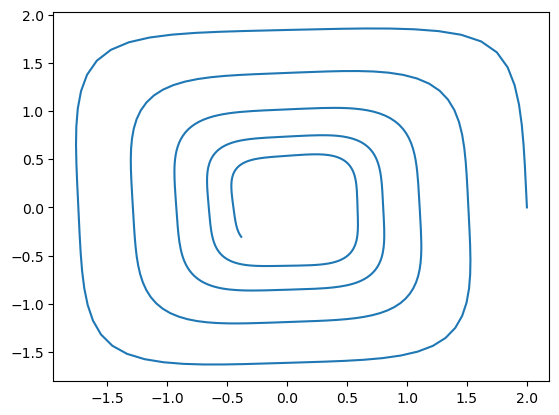

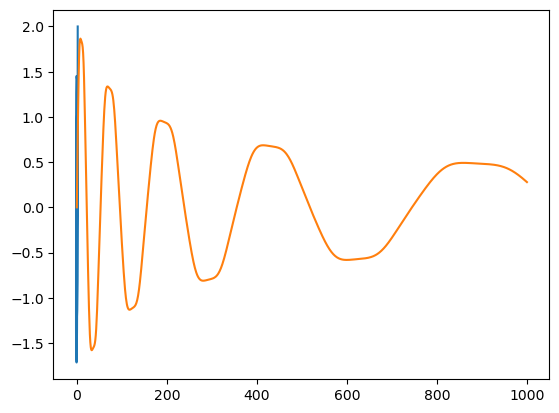

In [42]:
plt.plot(t2, y_pred)
plt.figure()
plt.plot(t2, torch.Tensor([i[0][0] for i in true_y]),  torch.Tensor([i[0][1] for i in true_y]))

In [13]:
all[0][0][1]

tensor(0., grad_fn=<SelectBackward0>)

In [14]:
len(all)

1000